In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import datetime as dt
import pyfolio as pf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
def shape(data):
    
    Open = data['Open']
    Close = data['Close']
    High = data['High']
    Low = data['Low']
    Low1 = data['Low']
    High1 = data['High1']
    Open1 = data['Open1']
    Close1 = data['Close1']
    
    if (Open < Close and Open > Low):
        if (High == Open):
                a = 1
                return a
        if (High > Close):
                b = 2
                return b
            
    if (Open < Close and Low == Open):
        if (Close > Open):
                c=3
                return c
        if (High == Close):
                d = 4
                return d
    
    if (Open > Close):
        if (Close == Low):
            if (High == Open):
                e = 5
                return e
            if (High > Open):
                f = 6
                return f
        if (Close > Low):
            if (High == Open):
                g= 7
                return g
            if (High > Open):
                h = 8
                return h
                            
    if (Open == Close):
        if (Open == Low):
            if (High > Close):
                i = 9
                return i
                
        if (High == Close):
            if (Low < Open):
                j = 10
                return j
                
        if (Close > Low):
            if (Open < High):
                k = 11
                return k
                
    if (Open == Close):
        if (High == Low):
            if (High > (High1+Close1)/2):
                l = 12
                return l
                
            if (Low <  (High1+Close1)/2):
                m = 13
                return m
            
            if (Open1 == Close1):
                if (Low1 == High1):
                    n= 14
                    return n

In [3]:
def position(data):
    
    Open = data['Open']
    Close = data['Close']
    High = data['High']
    Low = data['Low']
    Low1 = data['Low1']
    High1 = data['High1']
    Open1 = data['Open1']
    Close1 = data['Close1']
    
    if High > High1:
        if Low < Low1:
            if Close > Close1:
                return 1
            if Close < Close1:
                return 2
        if Low > Low1:
            if Close > Close1:
                return 3
            if Close < Close1:
                return 4
    if High < High1:
        if Low < Low1:
            if Close > Close1:
                return 5
            if Close < Close1:
                return 6
        if Low > Low1:
            if Close > Close1:
                return 7
            if Close < Close1:
                return 8

In [4]:
def vwap(data):
    vp = data["Close"]*data["Volume"]+data["Close1"]*data["Volume1"]
    v = data["Volume"]+data["Volume1"]
    return(vp/v) 

In [5]:
class strategy:
    
    def __init__(self,ticker,start_date,end_date,ema,split):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.ema = ema
        self.split = split#ratio to split training data
        self.fetch_data()#data fetching
        self.shift()#shifting data by a candle
        self.c_shape()#candle shapes
        self.position()#candle relative position
        self.indicators()#computing indicators
        self.signal()#generating signal
        self.ml_model()#machine learning model
        self.positions_and_returns()#taking long only position
        
        
        
    def fetch_data(self):
        self.data = yf.download(self.ticker,self.start_date,self.end_date)
        
    def shift(self):
        self.data['Low1'] = self.data['Low'].shift(1)
        self.data['High1'] = self.data['High'].shift(1)
        self.data['Open1'] = self.data['Open'].shift(1)
        self.data['Close1'] = self.data['Close'].shift(1)
        self.data['Volume1'] = self.data['Volume'].shift(1)
        
    def c_shape(self):
        self.data['c_shape'] = self.data.apply(shape, axis='columns')
        
    def position(self):
        self.data["C_position"] = self.data.apply(position,axis = "columns")
        
    def indicators(self):
        self.data["ema"] = ta.EMA(self.data["Adj Close"],timeperiod = self.ema)
        self.data["vwap"] = self.data.apply(vwap,axis = "columns")
        self.data["atr"] = ta.ATR(self.data["High"],self.data["Low"],self.data["Adj Close"])
        self.data["returns1"] = self.data["Close"].pct_change() 
        self.data["returns3"] = self.data["Close"].pct_change(periods = 3)
        self.data["returns7"] = self.data["Close"].pct_change(periods = 7)
        self.data['BBANDS_U'] = ta.BBANDS(self.data["Close"], timeperiod=21)[0]
        self.data['BBANDS_M'] = ta.BBANDS(self.data["Close"], timeperiod=21)[1]
        self.data['BBANDS_L'] = ta.BBANDS(self.data["Close"], timeperiod=21)[2]
    
    def signal(self):
        self.data["signal"] = 0
        self.data.loc[(self.data.vwap < self.data.ema)  & (self.data.BBANDS_M > self.data.BBANDS_L) & (self.data.BBANDS_M < self.data.BBANDS_U),"signal"] = 1
        self.data.loc[(self.data.vwap > self.data.ema)  & (self.data.BBANDS_M < self.data.BBANDS_L) & (self.data.BBANDS_M > self.data.BBANDS_U),"signal"] = -1
       
    def ml_model(self):
        alpha= pd.get_dummies(self.data["c_shape"])
        beta = pd.get_dummies(self.data["C_position"])
        ShapeEnc = pd.DataFrame()
        val = self.data["c_shape"].unique()

        for i in range(1,15):
            ShapeEnc[i] = 0
    
        for i in val:
            if i > 0:
                ShapeEnc[i] = alpha[i]
                
        ShapeEnc = ShapeEnc.astype(np.float)
        ShapeEnc = ShapeEnc.fillna(0)
        
        C_PositionEnc = beta.dropna()
        
        Enc = ShapeEnc.join(C_PositionEnc, how = 'left', lsuffix='-Shape', rsuffix='-CandlePos')
        
        features = self.data[["vwap","ema","BBANDS_L","BBANDS_M","BBANDS_U","returns1","returns3","returns7","atr","signal"]]
        
        for i in range(0,features.shape[1] - 1):
            features.iloc[:,i] = features.iloc[:,i] / features.iloc[:,i].rolling(window = 21).mean()
        
        df = features.join(Enc).dropna()
        X = df.drop("signal",axis = 1).dropna()
        y = df["signal"]
        
        dataset_length = df.shape[0]
        split_data = int(dataset_length * self.split)
        
        X_train, X_test = X[:split_data], X[split_data:]
        y_train, y_test = y[:split_data], y[split_data:]

        param_dist = {"max_depth": [3, None],
                      "max_features": randint(1, 9),
                      "min_samples_leaf": randint(1, 9),
                      "criterion": ["gini", "entropy"]}
  
        tree = RandomForestClassifier()
  
        tree_cv = RandomizedSearchCV(tree, param_dist, cv = 5)
  
        tree_cv.fit(X_train, y_train)

        print("Best Parameters: {}".format(tree_cv.best_params_))
        print("Best score is {}".format(tree_cv.best_score_))
        
        criterion = tree_cv.best_params_['criterion']
        max_depth = tree_cv.best_params_['max_depth']
        max_features = tree_cv.best_params_['max_features']
        min_samples_leaf = tree_cv.best_params_['min_samples_leaf']
        
        clf = RandomForestClassifier(criterion = criterion,
                                     max_depth = max_depth,
                                     max_features = max_features,
                                     min_samples_leaf = min_samples_leaf,
                                     random_state=100)
        
        model = clf.fit(X_train, y_train)
        
        print('Prediction (%): ', accuracy_score(y_test, model.predict(X_test), normalize=True)*100.0)
        
        report = classification_report(y_test, model.predict(X_test))
        print(report)
        
        #df['Predicted_Signal'] = 0
        df['Predicted_Signal'] = model.predict(X)
        
        df['position'] = 0
        df['position'] = df['Predicted_Signal'].replace(to_replace=0, method='ffill')
        df["position"] = df["position"].replace(to_replace = -1,value = 0)

        # Calculate log returns
        df['Return'] = np.log(self.data['Adj Close'] / self.data['Adj Close'].shift(1))
        df['Strategy_Return'] = df["Return"] * df.position
        print('Total return:',df['Strategy_Return'].iloc[split_data:].cumsum()[-1] )
        df[["Strategy_Return"]].iloc[split_data:].cumsum().plot(figsize=(14,10),grid = True)
        plt.ylabel("Strategy Prediction Returns")
        plt.show()
        
        df["cum_ret"] = df["Strategy_Return"].cumsum()
        df["CAGR"] = (((df["Strategy_Return"]/df["Strategy_Return"].shift(252))**1)-1)
        
        plt.figure(figsize=(14,10),constrained_layout = True) 
        plt.subplot(3, 1, 1)
        pf.plot_rolling_sharpe(df["Strategy_Return"].iloc[split_data:])
        plt.subplot(3, 1, 2)
        pf.plot_drawdown_underwater(df["Strategy_Return"].iloc[split_data:])
        plt.subplot(3, 1, 3)
        df["CAGR"].iloc[split_data:].plot(ylabel = "CAGR")
        
        plt.show()
        
    def positions_and_returns(self):
        self.data['position'] = self.data['signal'].replace(to_replace=0, method='ffill')
        self.data["position"] = self.data["position"].replace(to_replace = -1,value = 0)
        self.data['Return'] = np.log(self.data['Adj Close'] / self.data['Adj Close'].shift(1)) * self.data["position"]
    

In [6]:
end = dt.datetime(2021,12,1).date()
start = end-pd.Timedelta(days=10*252)

In [9]:
stock_list = ['WIPRO.NS',
              'TATAMOTORS.NS',
              'BAJAJFINSV.NS']

stock_name = []

******************************************************************************************************************************
BACKTESTING RESULT FOR WIPRO.NS
[*********************100%***********************]  1 of 1 completed
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 8}
Best score is 0.8923694779116467
Prediction (%):  88.22115384615384
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       317
           1       1.00      0.51      0.67        99

    accuracy                           0.88       416
   macro avg       0.93      0.75      0.80       416
weighted avg       0.90      0.88      0.87       416

Total return: 1.252109753726961


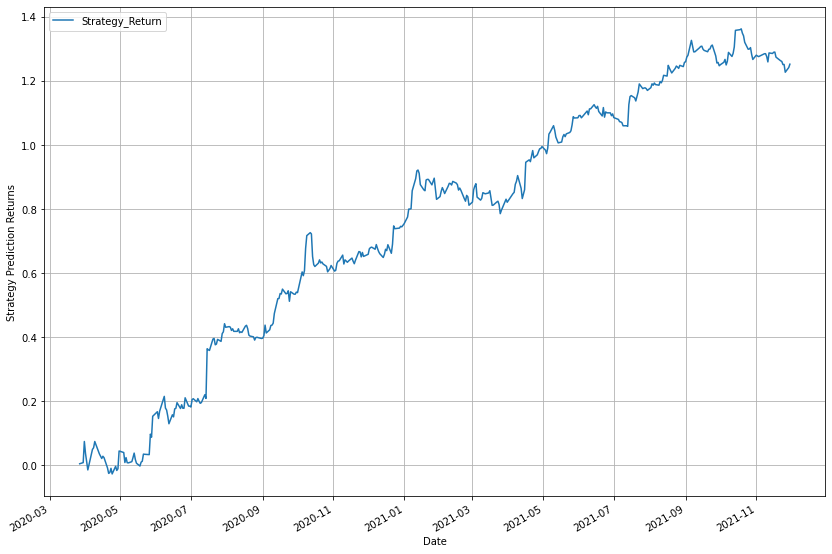

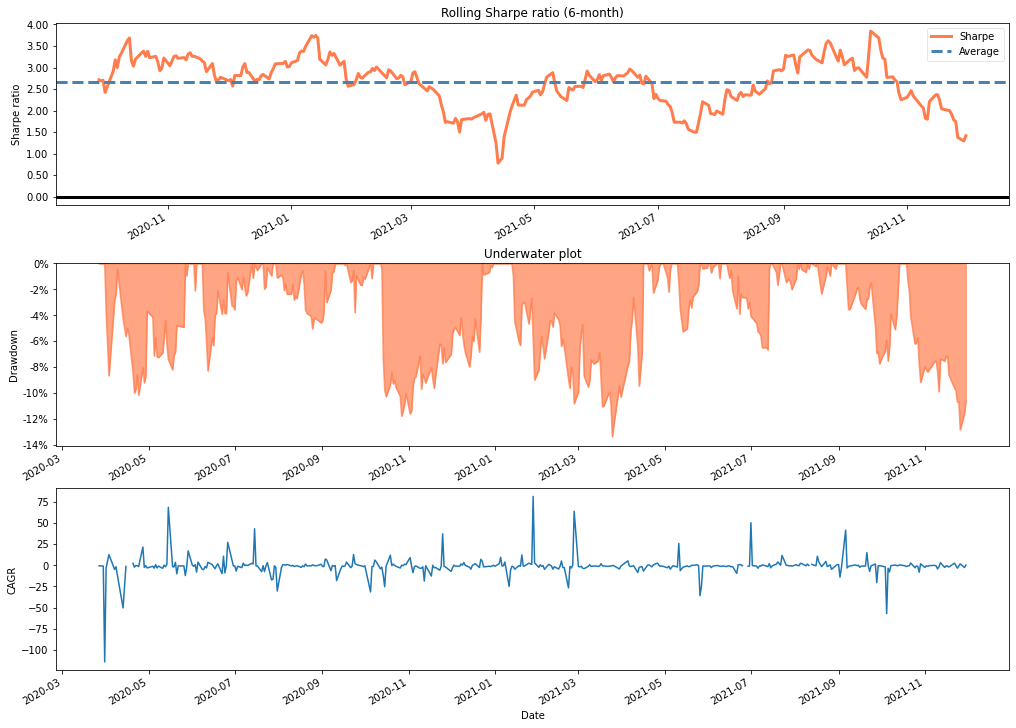

******************************************************************************************************************************
BACKTESTING RESULT FOR TATAMOTORS.NS
[*********************100%***********************]  1 of 1 completed
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 1}
Best score is 0.9485943775100403
Prediction (%):  93.75
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       288
           1       0.89      0.91      0.90       128

    accuracy                           0.94       416
   macro avg       0.92      0.93      0.93       416
weighted avg       0.94      0.94      0.94       416

Total return: 1.8683193399292248


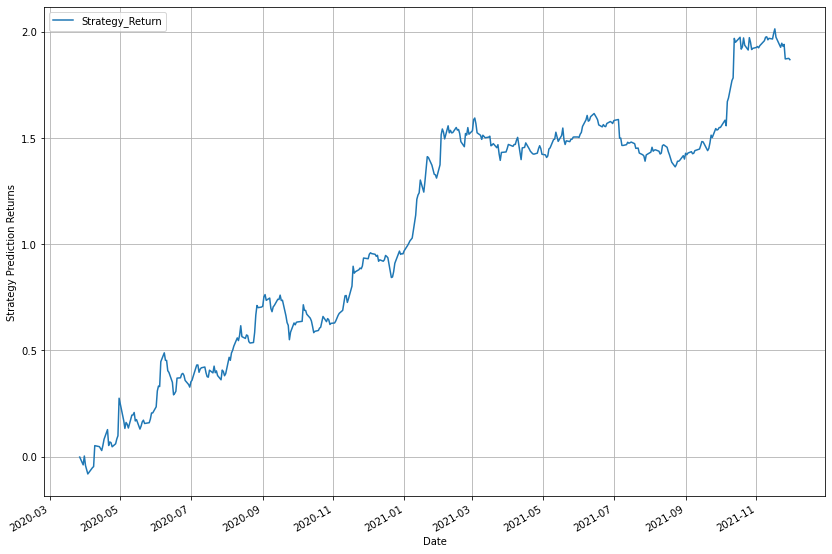

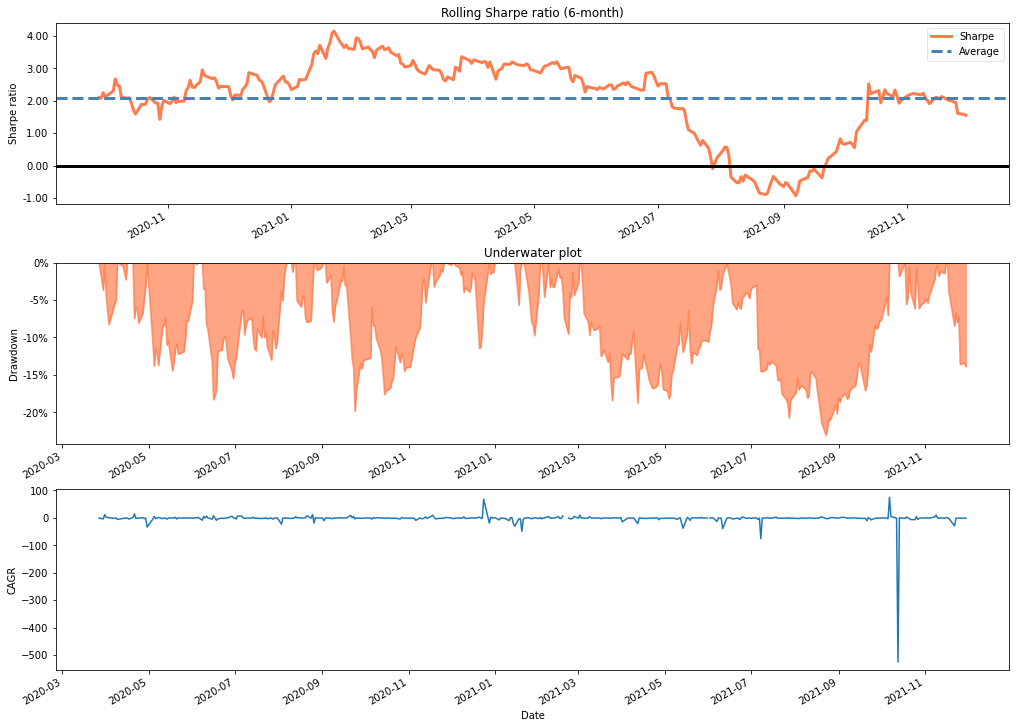

******************************************************************************************************************************
BACKTESTING RESULT FOR BAJAJFINSV.NS
[*********************100%***********************]  1 of 1 completed
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 2}
Best score is 0.946987951807229
Prediction (%):  95.1923076923077
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       285
           1       0.93      0.92      0.92       131

    accuracy                           0.95       416
   macro avg       0.95      0.94      0.94       416
weighted avg       0.95      0.95      0.95       416

Total return: 1.2088583301746765


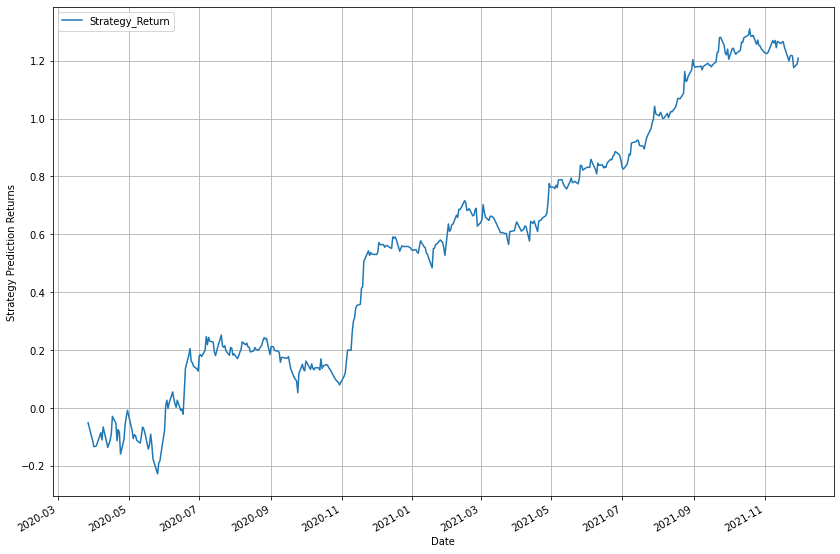

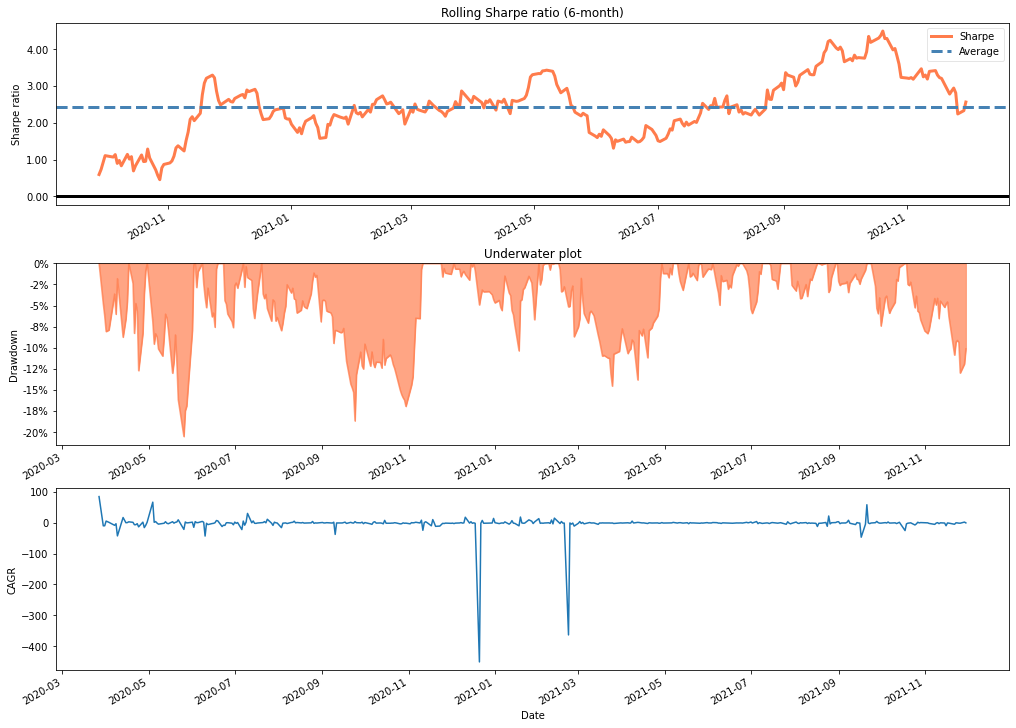

In [10]:
for stock in stock_list:
    print("******************************************************************************************************************************")
    print("BACKTESTING RESULT FOR",stock)
    a = strategy(stock,start,end,21,0.75)
    
    stock_name.append(stock)